

Architectural innovations in deep learning occur at a breakneck pace, yet fragments of legacy code often persist, carrying assumptions and practices whose necessity remains unquestioned. Practitioners frequently accept these inherited elements as optimal by default, rarely stopping to reevaluate their continued relevance or efficiency.

Input normalization for convolutional neural networks, particularly in image processing, is a prime example of these unscrutinized practices. This is especially evident in the widespread use of pre-trained models like VGG or ResNet, where specific normalization values have become standard across the community. In particular, the standard values used for ImageNet training are:

* Mean: `[0.485, 0.456, 0.406]` (for R,G,B channels respectively)
* Std: `[0.229, 0.224, 0.225]`

What is the origin of these values? Are they really important?

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.14602370.svg)](https://doi.org/10.5281/zenodo.14602370)
[![GitHub](https://img.shields.io/badge/github-%23121011.svg?style=for-the-badge&logo=github&logoColor=white)](https://github.com/laurentperrinet/2024-12-09-normalizing-images-in-convolutional-neural-networks)

<!-- TEASER_END -->

When consulting AI coding assistants like GitHub's Copilot, it tends to provide the following perspective:

>    Image normalization in convolutional neural networks (CNNs) has several beneficial effects:

>    1- Improved convergence: Normalization helps to stabilize and speed up the learning process by ensuring that pixel values are in a similar range, thus facilitating optimization.

>    2- Reduced sensitivity to scale variations: Normalizing images reduces the model's sensitivity to scale variations in pixel values, which can improve model robustness.

>    3- Prevention of neuron saturation: Unnormalized pixel values can lead to neuron saturation, which slows down learning. Normalization helps prevent this problem.

>    4- Improved performance: In general, image normalization can lead to better model performance in terms of accuracy and generalization.


The impact of varying input normalization values on neural network performance warrants closer examination. While conventional wisdom dictates specific normalization parameters for pre-trained models like VGG and ResNet, the fundamental properties of convolutional layers suggest these precise values may be arbitrary. Consider that:

1. The weights in the first convolutional layer are learned parameters
2. Convolution kernels can be scaled arbitrarily due to their weight and bias terms
3. The current practice of using highly precise three-digit normalization values seems unnecessarily specific

This investigation aims to demonstrate quantitatively that the exact normalization values matter less than commonly assumed. The analysis will proceed in two parts:

1. First, examining the classic [LeNet](https://en.wikipedia.org/wiki/LeNet) architecture on the MNIST dataset
2. Then, extending the investigation to the more modern [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network) architecture on ImageNet

This approach will help validate whether our rigid adherence to specific normalization values is truly justified by empirical evidence.


Let's first initialize the notebook:

In [1]:
import numpy as np
np.set_printoptions(precision=6, suppress=True)
import os

import matplotlib.pyplot as plt
phi = (np.sqrt(5)+1)/2
fig_width = 10
figsize = (fig_width, fig_width/phi)

In [2]:
%pip install -Uq -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
%mkdir -p data

## The MNIST challenge and the *French Touche* 

First, let's explore the *LeNet* network  (Lecun, Y.; Bottou, L.; Bengio, Y.; Haffner, P. (1998). "Gradient-based learning applied to document recognition" Proceedings of the IEEE. 86 (11): 2278–2324. doi:10.1109/5.726791. S2CID 14542261), whose objective is to categorize images of written digits, one of the first great successes of Multilayer neural networks. For this one, we're going to use the classic implementation, as proposed in the [PyTorch library of examples](https://github.com/pytorch/examples/). 



The cell below allows you to do everything: first load the libraries, then define the neural network, and finally define the learning and testing procedures that are applied to the database. The output accuracy value corresponds to the percentage of letters that are correctly classified.

In this cell, we'll isolate the two parameters used to set the mean and standard deviation applied to the normalization function, which we'll be manipulating in the course of this book.

In [4]:
# adapted from https://raw.githubusercontent.com/pytorch/examples/refs/heads/main/mnist/main.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# epochs = 15
epochs = 30 # a bit more than the original example which had 15 epochs

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # if verbose and batch_idx % log_interval  == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    if verbose:
        print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)


def main(mean, std, weight_init=None, bias_init=None, epochs=epochs, log_interval=100, verbose=False):
    # Training settings
    torch.manual_seed(1998) # FOOTIX rules !
    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}
    if torch.cuda.is_available():
        device = torch.device("cuda")
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    if mean is None:
        transform = transforms.ToTensor()
    else:
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))
            ])
    dataset1 = datasets.MNIST('data', train=True, download=True,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)

    dataset2 = datasets.MNIST('data', train=False,
                       transform=transform)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)

    if not bias_init is None:
        model.conv1.bias.data *= bias_init
    if not weight_init is None:
        model.conv1.weight.data *= weight_init

    
    optimizer = optim.Adadelta(model.parameters(), lr=1.0)
    # scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    scheduler = ReduceLROnPlateau(optimizer, 'max')
    for epoch in range(1, epochs+1):
        train(model, device, train_loader, optimizer, epoch, log_interval=log_interval, verbose=verbose)
        accuracy = test(model, device, test_loader, verbose=verbose)
        scheduler.step(accuracy)

    if verbose: print(f'The std of weight and bias in the first convolutional layer is {model.conv1.weight.std().item():.4f} and  {model.conv1.bias.std().item():.4f}')

    return accuracy


(You will notice that I made minor changes, such as using the `ReduceLROnPlateau` scheduler instead of `StepLR`. In practice, this only changed the values I could test - run the notebook with enough epochs and the other scheduler to see for yourself.)

Now that we've defined the entire protocol, we can test it in its most classic form, as delivered in the original code, with 3-digit precision:

In [5]:
accuracy = main(mean=0.1307, std=0.3081, verbose=True)
print(f'{accuracy=:.4f}')

Test set: Average loss: 0.0500, Accuracy: 9830/10000 (98%)
Test set: Average loss: 0.0362, Accuracy: 9874/10000 (99%)
Test set: Average loss: 0.0345, Accuracy: 9868/10000 (99%)
Test set: Average loss: 0.0325, Accuracy: 9895/10000 (99%)
Test set: Average loss: 0.0351, Accuracy: 9880/10000 (99%)
Test set: Average loss: 0.0382, Accuracy: 9882/10000 (99%)
Test set: Average loss: 0.0310, Accuracy: 9908/10000 (99%)
Test set: Average loss: 0.0356, Accuracy: 9896/10000 (99%)
Test set: Average loss: 0.0333, Accuracy: 9895/10000 (99%)
Test set: Average loss: 0.0348, Accuracy: 9907/10000 (99%)
Test set: Average loss: 0.0329, Accuracy: 9896/10000 (99%)
Test set: Average loss: 0.0278, Accuracy: 9920/10000 (99%)
Test set: Average loss: 0.0327, Accuracy: 9907/10000 (99%)
Test set: Average loss: 0.0301, Accuracy: 9914/10000 (99%)
Test set: Average loss: 0.0315, Accuracy: 9906/10000 (99%)
Test set: Average loss: 0.0357, Accuracy: 9905/10000 (99%)
Test set: Average loss: 0.0421, Accuracy: 9917/10000 (99

For image normalization in LeNet  the standard values used are for ImageNet training:

* `mean=0.1307`, 
* `std=0.3081`

These exact same numbers were first introduced in that code on [Jan 17, 2017](https://github.com/pytorch/examples/commit/32c7386aef93737926069ee284d827f8e954e086) and these exact values have not changed since (up to the 3rd digit). Why so?

For instance, another input normalization may trigger a higher accuracy : (more below to see how we get that value)

In [6]:
accuracy = main(mean=0.144, std=0.569)
print(f'{accuracy=:.4f}')

accuracy=0.9930



What is less known is that they may be retrieved from te datasets' statistics:

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

def compute_dataset_stats(dataset, batch_size=256, num_workers=4):
    """
    Calculate the channel-wise mean and standard deviation of a data set
    
    Args:
        dataset: the dataset to compute the statistics from
        batch_size: Batch size for loading data
        num_workers: Number of worker processes to load data
    
    Returns:
        Means: Means per channel
        stds: Channel-wise standard deviations
    """

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False
    )
    
    # Initialize variables for computing means
    mean = torch.zeros(3)
    mean_squared = torch.zeros(3)
    total_batches = 0
    
    print("Computing mean and standard deviation...")
    # First pass: compute mean
    for images, _ in tqdm(loader):
        # print(images.size()) # B x C x H x W
        # batch_samples = images.size(0)
        mean += images.mean(dim=(0, -2, -1))
        mean_squared += ((images - images.mean(dim=(0, -2, -1), keepdim=True))**2).mean(dim=(0, -2, -1))
        total_batches += 1
    
    mean = mean / total_batches
    std = torch.sqrt(mean_squared / total_batches)
    
    return mean, std


dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
means, stds = compute_dataset_stats(dataset)

print("MNIST stats on the train set:")
print(f"Mean: {means[0]:.4f}")
print(f"Std: {stds[0]:.4f}")


dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
means, stds = compute_dataset_stats(dataset)

print("MNIST stats on the test set:")
print(f"Mean: {means[0]:.4f}")
print(f"Std: {stds[0]:.4f}")

Computing mean and standard deviation...


100%|██████████| 235/235 [00:03<00:00, 71.95it/s] 


MNIST stats on the train set:
Mean: 0.1306
Std: 0.3079
Computing mean and standard deviation...


100%|██████████| 40/40 [00:02<00:00, 18.72it/s]

MNIST stats on the test set:
Mean: 0.1332
Std: 0.3110


The core idea here is that we train a network for given values so that whenever we feed in new input values, such as from the validation set, the batch will have similar first-order statistics. But is this hypothesis really important given the architecture of the network? 

Our implementation offers the flexibility to experiment with different normalization values (mean and standard deviation), allowing us to verify whether changing these initial parameters impacts the model's accuracy.

This way we can empirically test if the commonly used normalization values are truly special or if the network performs similarly with different normalization parameters.

Let's first see what happens without normalization:

In [8]:
accuracy = main(mean=None, std=None)
print(f'{accuracy=:.4f}')

accuracy=0.9931


Pretty much the same... but slightly better.

What if we use standard numbers?

In [9]:
accuracy = main(mean=0., std=1.)
print(f'{accuracy=:.4f}')

accuracy=0.9931


All these results seems similar, but it's not enough to demonstrate that setting the mean and standard deviation in input normalization has an effect on learning.

### computing accuracy on a regular grid of values

I'm now going to push the boat out further, using a library that allows me to test several values and thus optimize the parameters. If the mean and deviation are so important, we'll converge on a fixed set of values, whereas if they're less important, the values can be quite scattered. In particular, this will allow us to choose an arbitrary value, such as a mean of 0 and a standard deviation of 1, better known as *normal* normalization.

In [10]:
model = 'LeNet'
N_scan = 15

means = np.linspace(-2, 3., N_scan, endpoint=True)
stds = np.geomspace(0.02, 2., N_scan, endpoint=True)

path_save_numpy =  f'numpy-{model}.npy'
# %rm {path_save_numpy}
if not(os.path.isfile(path_save_numpy)):
    accuracy = np.empty((N_scan, N_scan))
    for i_mean, mean in enumerate(means):
        for i_std, std in enumerate(stds):
            accuracy[i_mean, i_std] = main(mean=mean, std=std, epochs=epochs)
    np.save(path_save_numpy, accuracy)
else:
    print(f'Loading {path_save_numpy}')
    accuracy = np.load(path_save_numpy)    

Loading numpy-LeNet.npy


/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_11037/4244923449.py:2: UserWarning: The following kwargs were not used by contour: 'n'
  CS = ax.contourf(means, stds, accuracy, n=20, cmap='viridis')


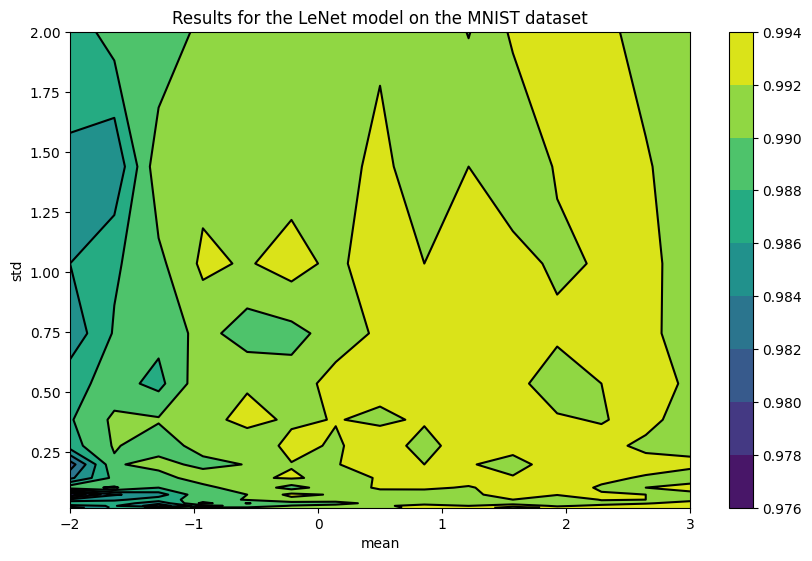

In [11]:
fig, ax = plt.subplots(figsize=figsize)
CS = ax.contourf(means, stds, accuracy, n=20, cmap='viridis')
CS2 = ax.contour(CS, levels=CS.levels, colors='k')
fig.colorbar(CS, ax=ax, extendfrac=0)
ax.set_title('Results for the LeNet model on the MNIST dataset')
ax.set_xlabel('mean')
ax.set_ylabel('std')
fig;

One is most certainly interested by the best value:

In [12]:
mean_max, std_max = np.unravel_index(np.argmax(accuracy), accuracy.shape)
print(f'Optimal value at indicies {mean_max, std_max}, with accuracy {accuracy[mean_max, std_max]:.4f}')

Optimal value at indicies (12, 7), with accuracy 0.9936


In [13]:
print(f'Optimal value: of mean={means[mean_max]:.4f}, std={stds[std_max]:.4f}')

Optimal value: of mean=2.2857, std=0.2000


Or by the barycenter of the accuracy map:

In [14]:
print(f'Center of gravity: {np.sum(means*accuracy)/np.sum(accuracy):.4f}, {np.sum(stds*accuracy)/np.sum(accuracy):.4f}')

Center of gravity: 0.5026, 0.4728


There is a low variabilty of the accuracy:

In [15]:
print(f'Variabity of accuracy: {np.std(accuracy):.4f}')

Variabity of accuracy: 0.0025


Mostly driven by the worst value:

In [16]:
mean_min, std_min = np.unravel_index(np.argmin(accuracy), accuracy.shape)
accuracy_min = accuracy[mean_min, std_min]
print(f'Worst value at indices {mean_min, std_min}, with accuracy {accuracy_min:.4f}')

Worst value at indices (4, 0), with accuracy 0.9779


In [17]:
print(f'Worst value: of mean={means[mean_min]:.4f}, std={stds[std_min]:.4f}')

Worst value: of mean=-0.5714, std=0.0200


The variability on the plateau (defined here as the set of 95% of best values) is very low:

In [18]:
accuracy_best95 = accuracy[accuracy >np.percentile(accuracy, .05)].flatten()
print(f'Mean of accuracy for the best 95%: {np.mean(accuracy_best95):.4f}')
print(f'Variabity of accuracy for the best 95%: {np.std(accuracy_best95):.4f}')

Mean of accuracy for the best 95%: 0.9908
Variabity of accuracy for the best 95%: 0.0023


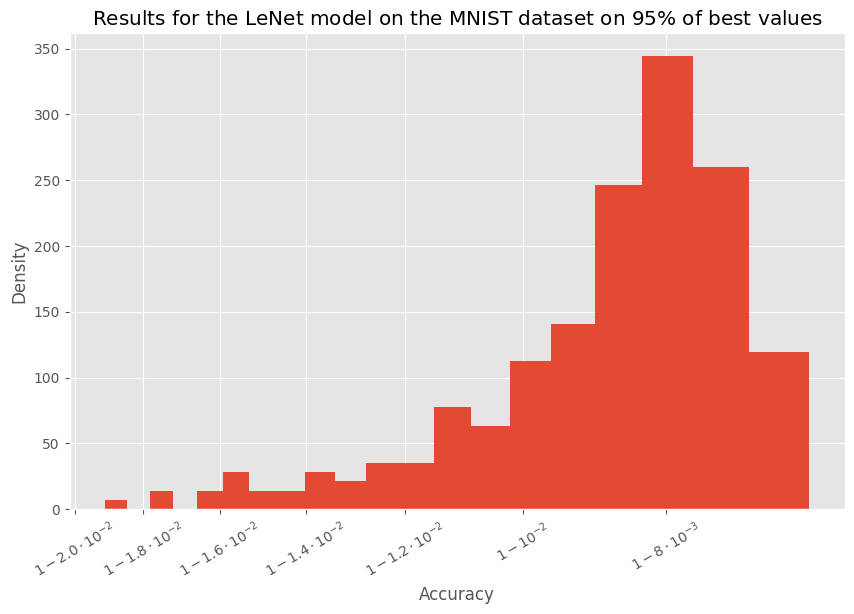

In [57]:
fig, ax = plt.subplots(figsize=figsize)
ax.hist(accuracy_best95, bins=20, density=True)
ax.set_title(r'Results for the LeNet model on the MNIST dataset on $95\%$ of best values')
ax.set_xlabel('Accuracy')
ax.set_xscale('logit')
plt.xticks(rotation=30)
ax.set_ylabel('Density')
fig;

Such that we can confidently say that we do not need a 3 digits initialization but that a standard input normalization would work as well, for instance: 

In [20]:
accuracy = main(mean=0.5, std=0.25, verbose=False)
print(f'{accuracy=:.4f}')

accuracy=0.9906


### Optimizing Normalization Parameters with Optuna
To more rigorously test our hypothesis about normalization parameters, we'll employ Optuna, a hyperparameter optimization library. This approach will allow us to:

1. Explore a diverse range of normalization values 
2. Test whether optimization converges to specific values (suggesting their importance) or remains scattered (suggesting flexibility)
3. Compare performance with standard normalization (e.g.  `mean = 0.5`, `std = 0.5`)

The non-regular grid search capability of Optuna is particularly valuable here, as it can help reveal whether the commonly used precise normalization values are truly optimal or if equivalent performance can be achieved across a broader range of parameters.

In [21]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [22]:
path_save_optuna =  f'optuna-{model}.sqlite3'
print(f'-> file {path_save_optuna} exists: {os.path.isfile(path_save_optuna)}')

-> file optuna-LeNet.sqlite3 exists: True


In [23]:
n_trials = 200

In [24]:
# %rm {path_save_optuna}

In [25]:
def objective(trial):
    mean = trial.suggest_float('mean', -1, 2., log=False)
    std = trial.suggest_float('std', 0.05, 1., log=True)
    accuracy = main(mean=mean, std=std, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model)
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'mean': 0.1440116283993092, 'std': 0.5690034868978842}
Best value:  0.9935


(Oh, that was where the value came from!)

/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_11037/2318167149.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
[W 2024-12-28 14:07:52,325] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


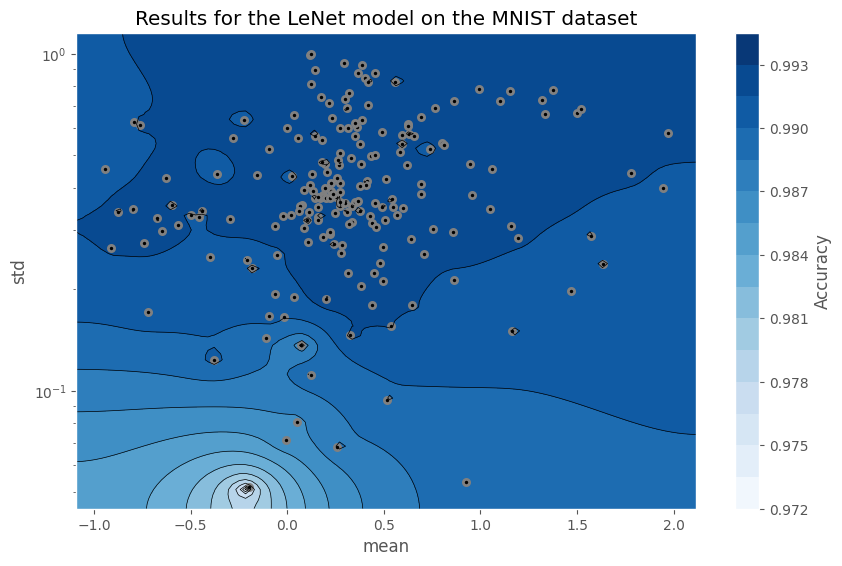

In [26]:
# https://optuna.readthedocs.io/en/stable/reference/visualization/matplotlib/generated/optuna.visualization.matplotlib.contour.html
from optuna.visualization.matplotlib import plot_contour

ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
fig = plt.gcf()
ax.set_title('Results for the LeNet model on the MNIST dataset')
fig.set_size_inches(figsize[0], figsize[1])

The observed pattern raises several interconnected questions about the network's design and behavior:

1. *The Redundancy Puzzle*:  Why do specific normalization values appear to matter when multiple mechanisms exist to compensate for input scaling? These mechanisms include: 
    1. Adjustable bias terms
    2. Learnable weight scaling
    3. Batch normalization layers

2. *The Historical Values Question*: What was the original process for determining these widely-used normalization parameters? Are they truly optimal, or simply the first values that worked well enough?

3. *The Initialization Mystery*:  How are the weights and biases in these layers initialized by default? What is the relationship between initialization schemes and input normalization?


These questions suggest that the interaction between input normalization, layer initialization, and network adaptation might be more complex than commonly assumed. 

For [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) and [nn.conv2D](https://pytorch.org/docs/stable/generated/torch.ao.nn.quantized.Conv2d.html), the weights are initialized from $\mathcal{U}(-\sqrt{k}, \sqrt{k})$, where $k = \frac{1}{\text{in\_features}}$ for the linear layer and $k = \frac{1}{C_\text{in} * \prod_{i=0}^{1}\text{kernel\_size}[i]}$.

This is done by [Glorot initialization](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_) :


In [27]:
conv1 = nn.Conv2d(1, 32, 3, 1)
print(f'The mean of weight and bias in the first convolutional layer is {conv1.weight.mean().item():.4f} and  {conv1.bias.mean().item():.4f}')
print(f'The std of weight and bias in the first convolutional layer is {conv1.weight.std().item():.4f} and  {conv1.bias.std().item():.4f}')
print(f' k= {1/3/3/1:.4f}, sqrt(k) = {np.sqrt(1/3/3/1):.4f}$')


The mean of weight and bias in the first convolutional layer is 0.0212 and  0.0181
The std of weight and bias in the first convolutional layer is 0.1869 and  0.1941
 k= 0.1111, sqrt(k) = 0.3333$


### using optuna to search for another initialization point


Let's see if for a given value for which we know the accuracy was worst (`mean=mean_min` and `std=std_min`), we can optimize the bias and weight intialization to get a better value, like that of the 95% best values obtained.

In [28]:
def objective(trial):
    weight_init = trial.suggest_float('weight_init', 0.05, 20., log=True)
    bias_init = trial.suggest_float('bias_init', 0.05, 20., log=True)
    accuracy = main(mean=-1, std=0.1, weight_init=weight_init, bias_init=bias_init, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model + '-init_WB')
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'weight_init': 0.307155100974441, 'bias_init': 5.5455929037599185}
Best value:  0.9941


Let's compare this accuracy value to the range of 95% of best values:

In [29]:
print(f'Mean of accuracy for the best 95%: {np.mean(accuracy_best95):.4f}')
print(f'Variabity of accuracy for the best 95%: {np.std(accuracy_best95):.4f}')

Mean of accuracy for the best 95%: 0.9908
Variabity of accuracy for the best 95%: 0.0023


So there's a clear  **yes** as we increase from the minimum value to a value exceeding the 95th percentile of the previously computed range.


## The ImageNet challenge and *residual networks* 

Second, let's tackle a real world problem set by the *ImageNet* challenge: image classification with 1 million images and 1000 labels. For this we will use the well-known Resnet model defined in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) as it givves a nice balance between simplicity and performance. In general, [Residual neural networks](https://en.wikipedia.org/wiki/Residual_neural_network) are widely used architectures for feed-forward networks applied to image categorization. 


https://pytorch.org/hub/pytorch_vision_resnet/

In [30]:
import torch
from torchvision.models import ResNet18_Weights

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.DEFAULT)
# or any of these variants 'resnet34', 'resnet50', 'resnet101', 'resnet152',
model

Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

For image normalization in ResNet (and many other computer vision models), the standard values used are for ImageNet training:

* Mean: `[0.485, 0.456, 0.406]` (for R,G,B channels respectively)
* Std: `[0.229, 0.224, 0.225]`

And which may be retrieved from the datasets' statistics:

In [31]:
import socket
print(socket.gethostname())

obiwan.local


In [34]:
if socket.gethostname() == 'CONECT-LID-01': # at the lab
    DATADIR = '/home/laurent/app54_nextcloud/2024_archives/2024_science/Deep_learning/data/Imagenet_full'
    DATADIR = '../Deep_learning/data/Imagenet_redux'
else:
    DATADIR = '/Volumes/SSD1TO/Deep_learning/data/Imagenet_full'
    DATADIR = '/Volumes/SSD1TO/Deep_learning/data/Imagenet_redux'
    DATADIR = '../Deep_learning/data/Imagenet_redux'

In [35]:
# Replace with your ImageNet data path
# Only transform to tensor and divide by 255
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()  # Scales data to [0,1]
])

for type in ['train', 'val']:
    dataset = torchvision.datasets.ImageFolder(f"{DATADIR}/{type}", transform=transform)
    means, stds = compute_dataset_stats(dataset)
    print(f"\nImageNet stats on the {type} set:")
    print(f"Means: R-{means[0]:.4f} G-{means[1]:.4f} B-{means[2]:.4f}")
    print(f"Stds: R-{stds[0]:.4f} G-{stds[1]:.4f} B-{stds[2]:.4f}")


Computing mean and standard deviation...


100%|██████████| 391/391 [01:54<00:00,  3.42it/s]



ImageNet stats on the train set:
Means: R-0.4851 G-0.4549 B-0.4035
Stds: R-0.2702 G-0.2625 B-0.2724
Computing mean and standard deviation...


100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


ImageNet stats on the val set:
Means: R-0.4798 G-0.4501 B-0.3989
Stds: R-0.2688 G-0.2611 B-0.2710



These values have become standard practice even when training on other datasets, although technically you could calculate and use dataset-specific normalization values.

These normalization values were first calculated in the early days of the rise of deep learning in computer vision, around 2012-2015. They come from calculating the mean and standard deviation per channel across the entire ImageNet training set of 1.2 million images, with the idea that each incoming batch should have the same first-order statistics. These values were widely adopted after the success of AlexNet (2012) and subsequent models such as VGG (2014) and ResNet (2015) on ImageNet.

These values have since become a de facto standard in computer vision, with frameworks like PyTorch and TensorFlow using them as default values in their model zoos and tutorials. They're particularly associated with models trained on ImageNet, though they're also often used when training on other datasets due to their proven effectiveness in practice.

### Training ResNet

The cell below allows you to do everything: first load the libraries, then define the neural network, and finally define the learning and testing procedures to be applied to the database. The output accuracy value corresponds to the percentage of correctly classified images. For simplicity, we use pre-trained weights and the retraining protocol used in [Jean-Nicolas Jérémie, Laurent U Perrinet (2023). Ultra-Fast Image Categorization in Biology and in Neural Models](https://laurentperrinet.github.io/publication/jeremie-23-ultra-fast-cat/) and available in the following code [UltraFastCat.ipynb](https://nbviewer.org/github/JNJER/2022-03_UltraFastCat/blob/main/UltraFastCat.ipynb)

In this cell, we'll isolate the two parameters used to set the mean and standard deviation applied to the normalization function we'll be manipulating throughout this book. Since we have color images, that is, 3 channels, this means that we are manipulating 6 variables.

In [36]:
epochs = 1

def train(model, device, train_loader, criterion, optimizer, epoch, log_interval=100, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if verbose and batch_idx % log_interval  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    if verbose:
        print('Test set: Av Accuracy: {}/{} ({:.0f}%)'.format(
            correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)

def main(mean_R, mean_G, mean_B, std_R, std_G, std_B, epochs=epochs, log_interval=100, verbose=False):
    # Training settings
    torch.manual_seed(1998) # FOOTIX rules !
    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}
    if torch.cuda.is_available():
        device = torch.device("cuda")
        cuda_kwargs = {'num_workers': 1,
                    #    'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((mean_R, mean_G, mean_B), (std_R, std_G, std_B))
        ])
    
    train_loader = torch.utils.data.DataLoader(datasets.ImageFolder(DATADIR + '/train', transform=transform), **train_kwargs)
    test_loader = torch.utils.data.DataLoader(datasets.ImageFolder(DATADIR + '/val', transform=transform), **test_kwargs)

    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.DEFAULT, verbose=False)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adadelta(model.parameters(), lr=1.0)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(1, epochs):
        train(model, device, train_loader, criterion, optimizer, epoch, log_interval=log_interval, verbose=verbose)
        scheduler.step()

    accuracy = test(model, device, test_loader, verbose=verbose)
    return accuracy


Now that we've defined the entire protocol, we can test it in its most classic form, as delivered in the original code by 6 numbers with 3 digits precision:

In [37]:
accuracy = main(0.485, 0.456, 0.406, 0.229, 0.224, 0.225)
print(f'{accuracy=:.4f}')

accuracy=0.6991


Accuracy without retraining:

In [38]:
accuracy = main(0.485, 0.456, 0.406, 0.229, 0.224, 0.225, epochs=0)
print(f'{accuracy=:.4f}')

accuracy=0.6991


What does it yield with single-digits parameters?

In [39]:
accuracy = main(0.5, 0.5, 0.5, 0.5, 0.5, 0.5)
print(f'{accuracy=:.4f}')

accuracy=0.6384


### using numpy to scan for different parameter values


Let's scan the parameters:

In [40]:
model = 'ResNet'

In [41]:
N_scan = 15
means = np.linspace(-3, 3, N_scan, endpoint=True)
stds = np.geomspace(0.05, 1., N_scan, endpoint=True)

path_save_numpy =  f'numpy-{model}.npy'
if not(os.path.isfile(path_save_numpy)):
    accuracy = np.empty((N_scan, N_scan))
    for i_mean, mean in enumerate(means):
        for i_std, std in enumerate(stds):
            accuracy[i_mean, i_std] = main(mean, mean, mean, std, std, std, epochs=epochs)

    np.save(path_save_numpy, accuracy)
else:
    accuracy = np.load(path_save_numpy)

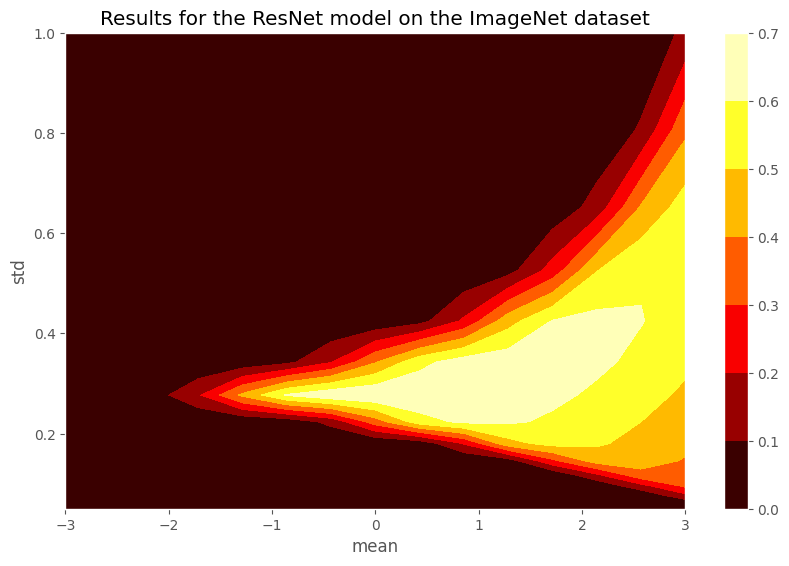

In [42]:
fig, ax = plt.subplots(figsize=figsize)
pcm = ax.contourf(means, stds, accuracy, cmap='hot')
fig.colorbar(pcm, ax=ax)
ax.set_title('Results for the ResNet model on the ImageNet dataset')
ax.set_xlabel('mean')
ax.set_ylabel('std')
fig;

Let's zoom around the central region

In [43]:
N_scan = 15
means = np.linspace(-.5, 1.5, N_scan, endpoint=True)
stds = np.geomspace(0.20, 0.6, N_scan, endpoint=True)

path_save_numpy =  f'numpy-{model}-zoom.npy'
if not(os.path.isfile(path_save_numpy)):
    accuracy = np.empty((N_scan, N_scan))
    for i_mean, mean in enumerate(means):
        for i_std, std in enumerate(stds):
            accuracy[i_mean, i_std] = main(mean, mean, mean, std, std, std, epochs=epochs)
    np.save(path_save_numpy, accuracy)
else:
    accuracy = np.load(path_save_numpy)

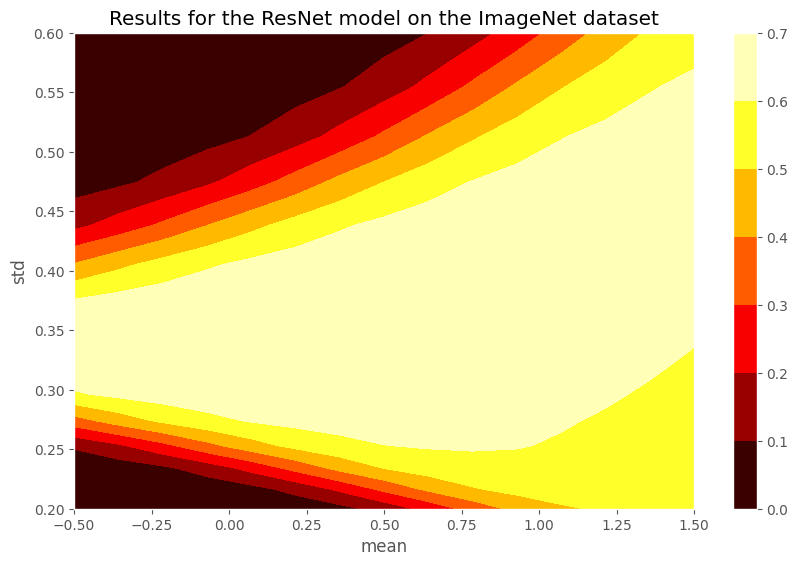

In [44]:
fig, ax = plt.subplots(figsize=figsize)
pcm = ax.contourf(means, stds, accuracy, cmap='hot')
fig.colorbar(pcm, ax=ax)
ax.set_title('Results for the ResNet model on the ImageNet dataset')
ax.set_xlabel('mean')
ax.set_ylabel('std')
fig;

As for LeNet, it appears that the networks' accuracy is robust for a large class of input normalization values.

### using optuna to search for another initialization point


And now with optuna:

In [45]:
path_save_optuna =  f'optuna-{model}.sqlite3'

In [46]:
# %rm {path_save_optuna}

In [47]:
def objective(trial):
    mean = trial.suggest_float('mean', -.5, 1.5, log=False)
    std = trial.suggest_float('std', 0.20, 0.6, log=True)
    accuracy = main(mean, mean, mean, std, std, std, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model)
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'mean': 0.45813765422778663, 'std': 0.23579097981269004}
Best value:  0.69398


In [48]:
path_save_optuna, len(study.get_trials())

('optuna-ResNet.sqlite3', 200)

In [49]:
study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)

/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_11037/1797386942.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
[W 2024-12-28 14:20:10,875] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


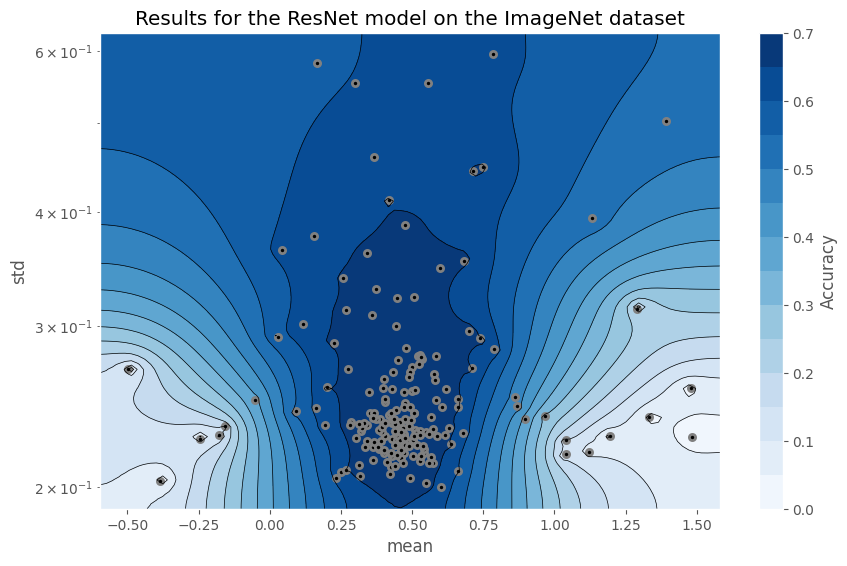

In [50]:
# https://optuna.readthedocs.io/en/stable/reference/visualization/matplotlib/generated/optuna.visualization.matplotlib.contour.html
from optuna.visualization.matplotlib import plot_contour

ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
ax.set_title('Results for the ResNet model on the ImageNet dataset')
fig = plt.gcf()
fig.set_size_inches(figsize[0], figsize[1])

### Conclusion

Here, we have shown that the values used for input normalisation in standard CNNs like LeNet or ResNet are mainly used for historical reasons and that:

- these are computed by computing first- and second-order statistics on pixels values from the dataset,
- these may be arbitrarily changed in a broad range given that we can re-train parameters of the network accordingly.

Long story short: it's ok to still use these values in three-digits precision just to remind us of where they come from.

### Appendix : looking for optimal values in RGB space

We can further explore the 6-dimensional space:


In [51]:
def objective(trial):
    mean_R = trial.suggest_float('mean_R', -1, 2., log=False)
    mean_G = trial.suggest_float('mean_G', -1, 2., log=False)
    mean_B = trial.suggest_float('mean_B', -1, 2., log=False)
    std_R = trial.suggest_float('std_R', 0.05, 1., log=True)
    std_G = trial.suggest_float('std_G', 0.05, 1., log=True)
    std_B = trial.suggest_float('std_B', 0.05, 1., log=True)
    accuracy = main(mean_R, mean_G, mean_B, std_R, std_G, std_B, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model + '-RGB')
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'mean_R': 0.5759977076117301, 'mean_G': 0.6686394118656815, 'mean_B': 0.7427398194700434, 'std_R': 0.30742014985012184, 'std_G': 0.36756360234262425, 'std_B': 0.4110226547110426}
Best value:  0.66928


In [52]:
def objective(trial):
    mean_R = trial.suggest_float('mean_R', .40, .60, log=False)
    mean_G = trial.suggest_float('mean_G', .40, .60, log=False)
    mean_B = trial.suggest_float('mean_B', .40, .60, log=False)
    std_R = trial.suggest_float('std_R', .15, .35, log=True)
    std_G = trial.suggest_float('std_G', .15, .35, log=True)
    std_B = trial.suggest_float('std_B', .15, .35, log=True)
    accuracy = main(mean_R, mean_G, mean_B, std_R, std_G, std_B, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model + '-RGB_fine')
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'mean_R': 0.46310177333629443, 'mean_G': 0.470980296382525, 'mean_B': 0.5076892083068535, 'std_R': 0.23876253734074915, 'std_G': 0.23201577544899127, 'std_B': 0.2834836298850044}
Best value:  0.6961


/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_11037/2577725987.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
[W 2024-12-28 14:20:11,436] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_11037/2577725987.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
[W 2024-12-28 14:20:11,502] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_11037/2577725987.py:4: ExperimentalWarning:

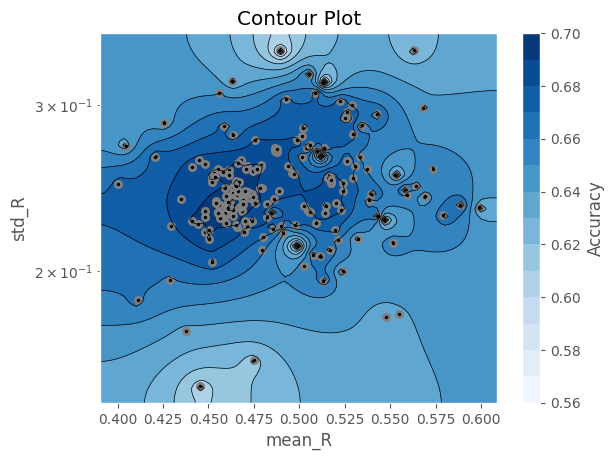

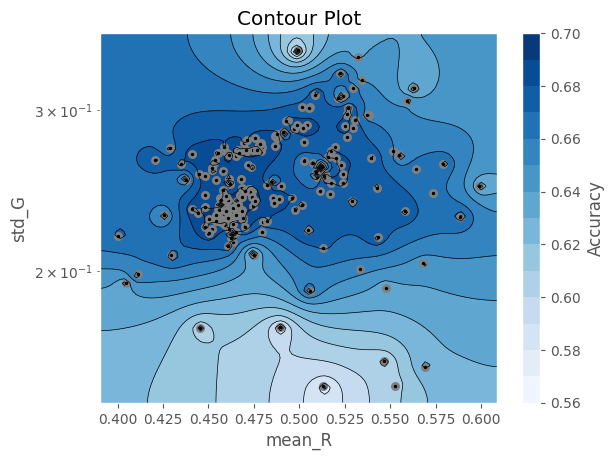

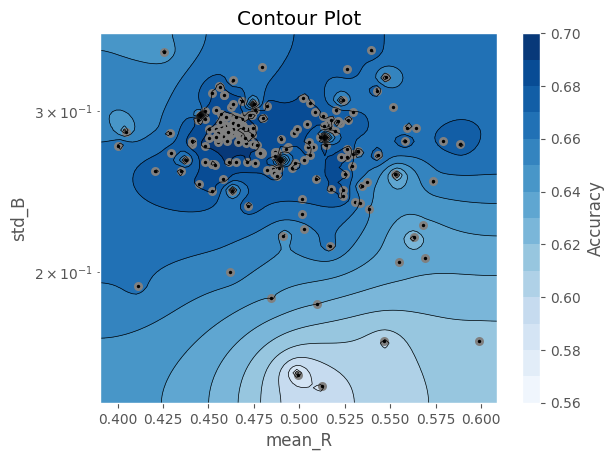

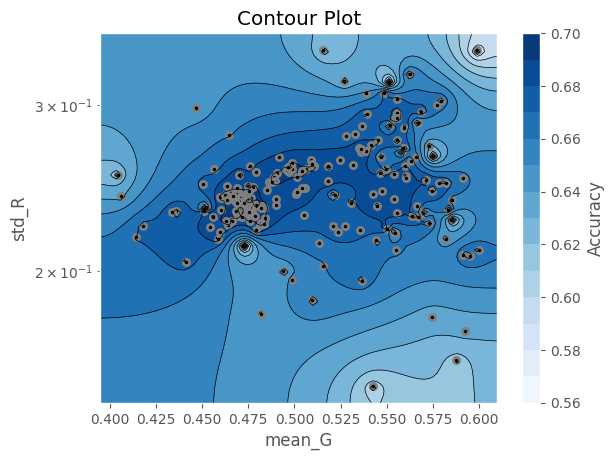

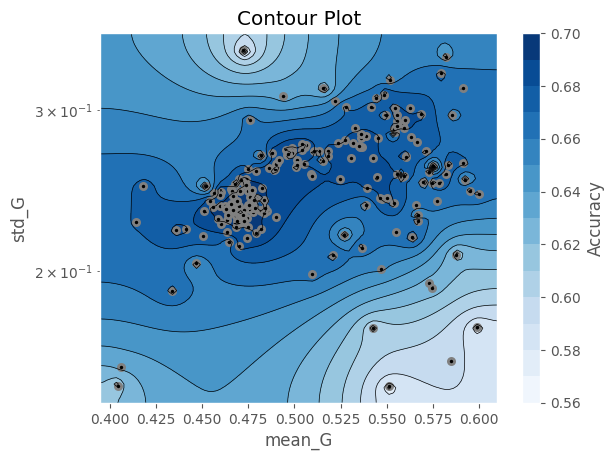

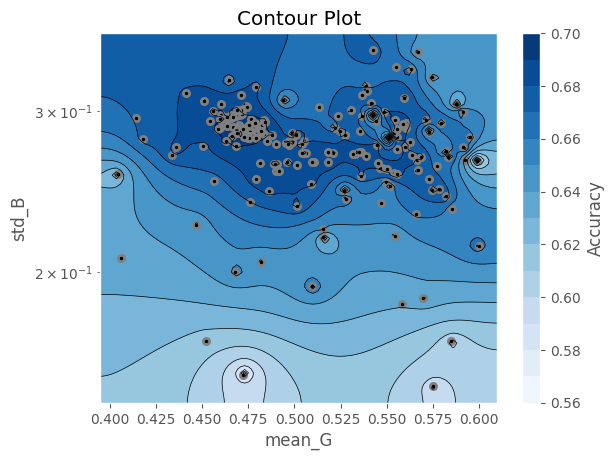

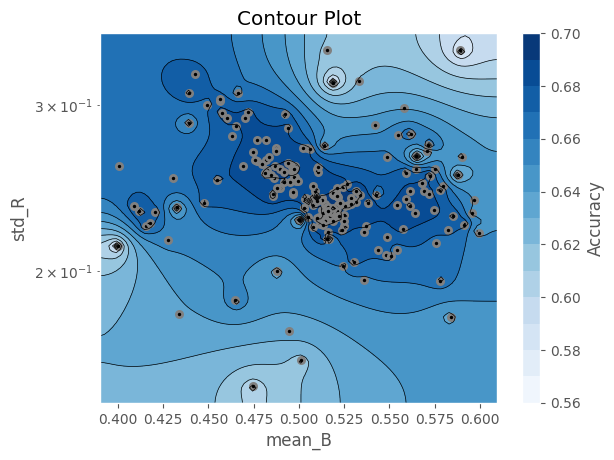

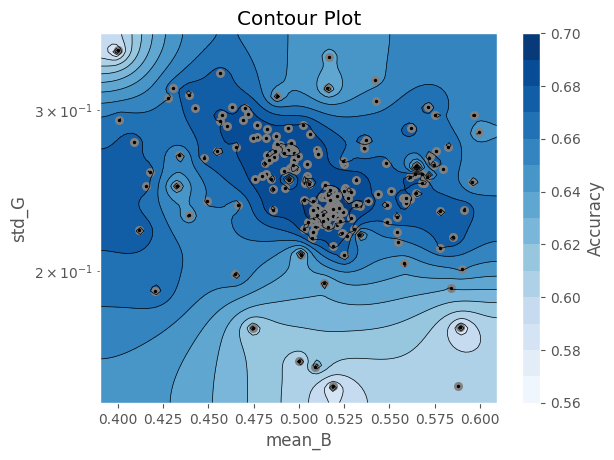

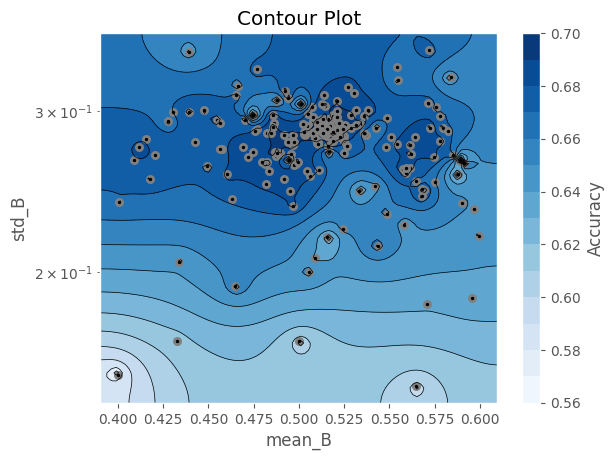

In [53]:
# fig, axs = plt.subplots(3, 3, figsize=figsize)
for i, c_mean in enumerate(['R', 'G', 'B']):
    for j, c_std in enumerate(['R', 'G', 'B']):
        ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
        # ax.set_title('Results for the ResNet model on the ImageNet dataset')

/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_11037/2013726993.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["mean_R", "mean_G", "mean_B", "std_R", "std_G", "std_B"])


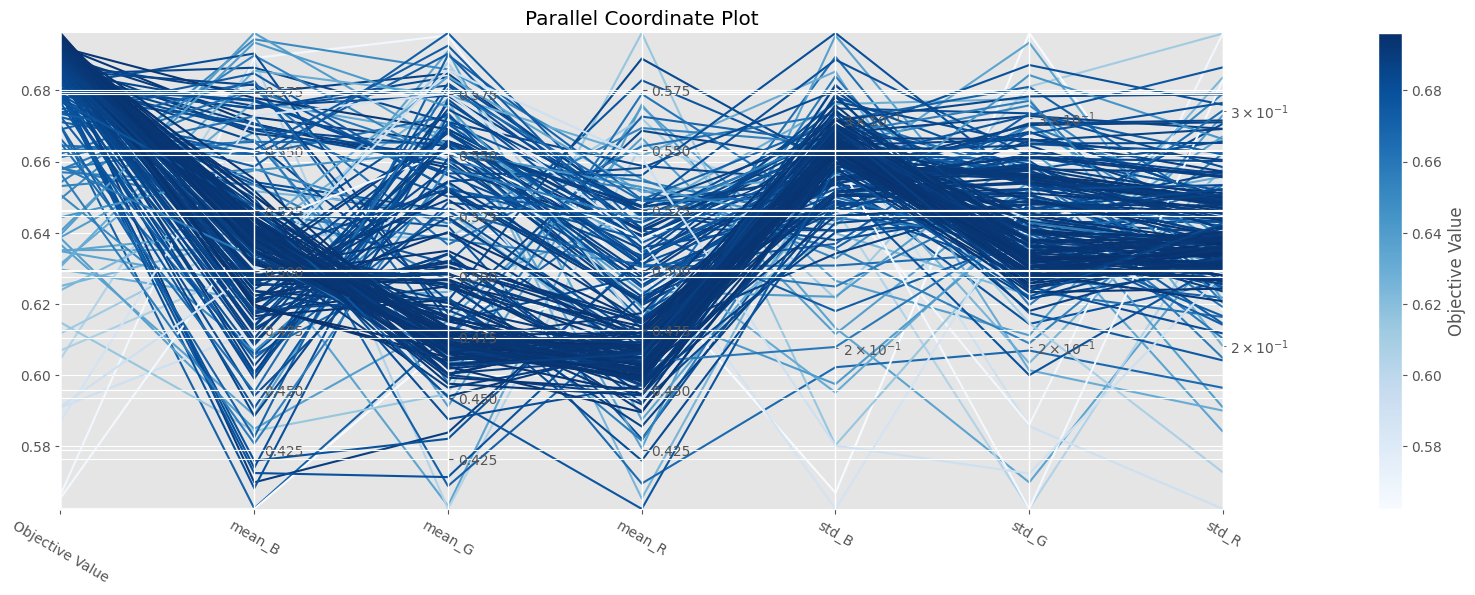

In [54]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["mean_R", "mean_G", "mean_B", "std_R", "std_G", "std_B"])
plt.gcf().set_size_inches(figsize[0]*2, figsize[1])

## some book keeping for the notebook

In [55]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,matplotlib,torch  -r -g -b

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.31.0

numpy     : 1.26.4
matplotlib: 3.10.0
torch     : 2.5.1

Compiler    : Clang 16.0.0 (clang-1600.0.26.4)
OS          : Darwin
Release     : 24.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

Hostname: obiwan.local

Git hash: 6f929d60f8477be3fe305092faa09ffc0f2dac41

Git repo: https://github.com/laurentperrinet/2024-12-09-normalizing-images-in-convolutional-neural-networks.git

Git branch: main

